## Create a DataFrame from the Trove dataset

### Obtaining the data

You can download the whole Trove dataset using:

`wget --recursive --no-parent http://overproof.projectcomputing.com/datasets/`

Change the parent directory `overproof.projectcomputing.com` to a friendlier name `trove_overproof`.

### Preprocessing of the data

In [2]:
from glob import glob
import os
import pandas as pd
import re
import jellyfish
import numpy as np

In [3]:
# Dictionary with the following structure:
# arbitrary_dirname: path_to_txt_files
# dirname is an arbitrary name which can be used to filter the DB in later steps

dict_dirnames = {
    "trove_dataset_1": './trove_overproof/datasets/dataset1/rawTextAndHumanCorrectionPairs',
    "trove_dataset_2": './trove_overproof/datasets/dataset2/rawTextAndHumanCorrectionAndOverproofCorrectionTriples',
    "trove_dataset_3": './trove_overproof/datasets/dataset3/rawTextAndHumanCorrectionAndOverproofCorrectionTriples'
}

In [4]:
df = pd.DataFrame(columns=["filePath", "articleId", "articleType", "year", "ocrText", "humanText", "corrected"])

In [5]:
def process_header(line):
    re_header = r'^\*\$\*OVERPROOF\*\$\*\s*([0-9]+)\s+year\s+([0-9]{4})\s+type\s(.+)\s+title\s+.+$'
    if re.match(re_header, line):
        articleId, year, articleType = re.match(re_header, line).groups()
        return articleId, year, articleType

In [6]:
def process_content(article_content):
    ocr_line = []
    human_line = []
    hcorr_line = []
    for line in article_content:
        line = line.split("||@@||")
        if len(line) == 3:
            ocr_line.append(line[0].strip())
            human_line.append(line[1].strip())
            hcorr_line.append(line[2].strip())
        if len(line) == 2:
            ocr_line.append(line[0].strip())
            human_line.append(line[1].strip())
    
    return " ".join(ocr_line), " ".join(human_line), " ".join(hcorr_line)

In [7]:
article_content = []
year = ""
file_path = ""
articleId = ""
articleType = ""
processed_content = ""
article_counter = 0
for ldir in dict_dirnames.keys():
    list_files = glob(os.path.join(dict_dirnames[ldir], "*.txt"))
    for lfile in list_files:
        file_path = lfile
        fio = open(lfile, "r")
        flines = fio.readlines()
        for iline in range(len(flines)):
            if flines[iline].startswith('*$*OVERPROOF*$*'):
                articleId, year, articleType = process_header(flines[iline])
                article_counter += 1
            else:
                article_content.append(flines[iline])
                if ((len(flines) -1 == iline) or (flines[iline + 1].startswith('*$*OVERPROOF*$*'))):
                    processed_content = process_content(article_content)

                    # Insert into dataframe:
                    df.loc[article_counter] = [file_path, 
                                               articleId,
                                               articleType,
                                               year,
                                               processed_content[0],
                                               processed_content[1],
                                               processed_content[2]
                                              ]  
                    
                    # Clean variables:
                    year = ""
                    articleId = ""
                    articleType = ""
                    processed_content = ""
                    article_content = []

print(article_counter)

30509


In [8]:
df.head()

,filePath,articleId,articleType,year,ocrText,humanText,corrected
1,./trove_overproof/datasets/dataset1/rawTextAnd...,18378453,Article ILLUSTRATED,1953,"FROM RIVER CROSSING TO END OF TRIÄÜ I ^PI A^H""...",FROM RIVER CROSSING TO END OF TRIAL SPLASH: Pe...,
2,./trove_overproof/datasets/dataset1/rawTextAnd...,18363627,Article,1953,"Natural Childbirth Sir,-We nurses have seen fa...","Natural Childbirth Sir,-We nurses have seen fa...",
3,./trove_overproof/datasets/dataset1/rawTextAnd...,18366055,Article,1953,FIRST CHURCH I SERVICE 1 Presbyterian I ' Anni...,FIRST CHURCH SERVICE Presbyterian Anniversary ...,
4,./trove_overproof/datasets/dataset1/rawTextAnd...,18386137,Article,1953,"""Bob"" Lulham's Fight Against Thallium District...","""Bob"" Lulham's Fight Against Thallium Arthur ...",
5,./trove_overproof/datasets/dataset1/rawTextAnd...,18368961,Article,1953,"DIVORCE Before The Judge In Divorce, Mr Justic...","DIVORCE Before The Judge In Divorce, Mr. Justi...",


### Add string similarity and length

In [9]:
def distance_via_levenshtein(gs_clean, ocr_clean):
    gs_clean = gs_clean.lower()
    ocr_clean = ocr_clean.lower()
    max_sentlength = max(len(gs_clean), len(ocr_clean))
    lev_distance = jellyfish.levenshtein_distance(gs_clean, ocr_clean)
    dist_similarity = (max_sentlength - lev_distance) / float(max_sentlength)
    return dist_similarity

In [10]:
df['str_similarity'] = df.apply(lambda row: distance_via_levenshtein(row['ocrText'], row['humanText']), axis = 1)
df['str_length'] = df.apply(lambda row: len(row['humanText']), axis = 1)

In [11]:
# Number of documents that have at least one article with string similarity lower than 0.8:
len(df[df['str_similarity'] < 0.8]['articleId'].unique())

5067

In [13]:
def quality(similarity):
    if similarity > 0.9:
        return 1 # good
    elif similarity > 0.8:
        return 2 # soso
    elif similarity > 0.7:
        return 3 # bad
    return 4 # ugly

df['quality_band'] = df["str_similarity"].apply(quality)

In [24]:
df['quality_band'].value_counts()

2    13952
1    11473
3     3592
4     1492
Name: quality_band, dtype: int64

### OCR and GS string similarity distribution

Plot the distribution of sentences according to string similarity between OCR and GS text:

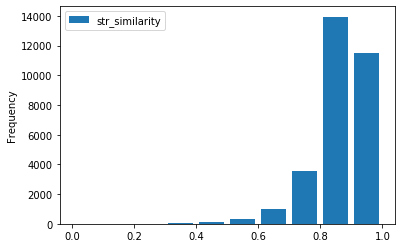

In [25]:
df[['str_similarity']].plot(kind='hist',bins=[0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0],rwidth=0.8)

Get some examples from each bin:

In [26]:
df[(df['str_similarity'] > 0.7) & (df['str_similarity'] <= 0.8)].sample(6).loc[:, ['ocrText', 'humanText']]

,ocrText,humanText
25516,"THE ASSAULT ON WILLIAM KIRK. GOSFORD, Wcdupsdi...","THE ASSAULT ON WILLIAM KIRK. GOSFORD, Wednesda..."
3783,CBAltQE OF DIGAMY. I -* In the Balmain Police ...,CHARGE OF BIGAMY. In the Balmain Police Court...
4013,CRICKET. A meeting of tho committeo of tho N S...,CRICKET. A meeting of the committee of the N.S...
11261,"PROJrCTTD DH'IRTIRIS-Jiirch 20 I lïrcmen, OMS,...","PROJECTED DEPARTURES.—March 20. Bremen, G.M.S...."
2944,"I ASHFIELD. . """" I A mecimg of this connell WO...",ASHFIELD. A meeting of this council was held o...
2920,ROOKWOOD. A meeting of tho nbovo council was h...,ROOKWOOD. A meeting of the above council was h...


In [27]:
df.to_pickle("db_trove.pkl")

In [28]:
trovedf = df

dExamples = dict()
for i in np.arange(0.1, 1.1, 0.1):
    tempdf = trovedf[(trovedf['str_similarity'] > (i - 0.1)) & (trovedf['str_similarity'] <= i) & (abs(trovedf['ocrText'].str.len() - trovedf['humanText'].str.len()) <= 100)]
    if tempdf.shape[0] >= 1:
        dExamples[((i - 0.1, i))] = (tempdf.shape[0], tempdf.iloc[0].filePath, tempdf.iloc[0].ocrText, tempdf.iloc[0].humanText)

for example in dExamples:
    print("Range:", example)
    print("Number of articles:", dExamples[example][0])
    print("Example: ./" + dExamples[example][1])
    print("\nOCR text:")
    print(dExamples[example][2])
    print("\nHuman-corrected text:")
    print(dExamples[example][3])
    print()
    print('==========')
    print()

Range: (0.30000000000000004, 0.4)
Number of articles: 9
Example: ././trove_overproof/datasets/dataset1/rawTextAndHumanCorrectionPairs/smh1923.txt

OCR text:
NORTH ROCKS FAIR. M tin- iiiiiiunl liir tit Nui Hi Kui.« in "W .>* Hie lot ni Si boni ni Wth Hie i» mis »on -lorry liuisc-i l> llutclic, 1 II I MMIICI, - l'onln It li null, «m1 Ululer S Smith, I I Munich 2 l'oiilci, to 11 J limul- \ Hull 1 renier-, ist - list liiicK Muck nell 1, s sini.li, > lot luck I irtler, 1, S Smith 2 rruil hrimci * turnciit G Iliuiie« 1, It I Muller, : Penn li lok I Hull 1 Sulkl runiout \ Hull, 1 Pcnteisiut, 2 l'uni jump ('. Iliuhe ( liiiiupioti rll.li n nom uiilci II IUIIIIN \ Hull Uiniiipiim rililmn linn I mir llreiinli l'cmi 11 linns uiul un le r ld », | Smith Llminiilon rib lui MIII.II Imn tin m ut l' lliigln» Ollin nuit- lesillcil III. tailem -Um« nillir illirs W spinnt Cul- un UM II er-- W une \t lus (ni-, niilor 1 lu 11 nine smith nul I h le Snllli lied It is nillir lilli- UiHiil-i 1! l'mler X e it e h